In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import scipy.optimize as optimization

In [2]:
class MarkowitzModel:
    def __init__(self, stocks, start_date, end_date):
        self.stocks = stocks.copy()
        self.start_date = start_date
        self.end_date = end_date
        # self.dataset = None

        # Пусть будет 100% в год (хотим удвоить).  
        # x^365 = 2, x - доходность акций
        # x = 1.00190084
        # Берём логарифм. ln(x) = 0.000824740721
        # Модель заменяет её сложную динамику на линейную модель. То есть берёём вместо x среднюю доходность и делаем вид, что она постоянно такая
        # self.DOHOD = 0.000824740721
        self.DOHOD = 0.015 # 0.0015
    
    def download_data(self, stdate, endate):
        # df = {}
        # for stock in self.stocks:
        #     ticker = yf.Ticker(stock)
        #     df[stock] = ticker.history(start = self.start_date, end = self.end_date, period='1mo')['Close']
        # return pd.DataFrame(df)
        stock_data = yf.download(self.stocks, start = stdate, end = endate, interval='1mo')
        stock_data = stock_data.dropna()
        return stock_data
    
    def show_data(self, data):
        plt.figure(figsize = (18,6))
        plt.grid(True)
        # plt.xlabel('Expected Volatility')
        # plt.ylabel('Expected Return')
        # plt.colorbar(label = 'Sharp Ratio')
        for stock in self.stocks:
            plt.plot(data['Adj Close'][stock])
        plt.legend(self.stocks, loc='right')
        plt.show()
        # data.plot(figsize = (18,5))
        # plt.show()
        

    def calculate_return(self, data):
        # log_return = np.log(data / data.shift(1))
        # return log_return[1:]
        df = {}
        for stock in self.stocks:
            df[stock] = data['Adj Close'][stock].pct_change()
            
        return pd.DataFrame(df)

    def show_statistics(self, returns):
        #annual return using mean
        print(returns.mean())

        #remember covariance is matrix so it will return that
        print(returns.cov())
    
    def show_mean_variance(self, returns, weights):
        portfolio_return = np.sum(returns.mean() * weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
        print("Expected portfolio mean(return):", portfolio_return)
        print("Expected portfolio volatility(standart deviation):", portfolio_volatility)

    def generate_portfolios(self, returns):
        portfolio_means = []
        portfolio_risks = []
        portfolio_weights = []

        for i in range(10000):
            w = np.random.random(len(self.stocks))
            w /= np.sum(w)
            portfolio_weights.append(w)
            # returns.mean() -  среднее по одной акции на протяжении всего времени
            portfolio_means.append(np.sum(returns.mean() * w))
            portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov(), w))))

        return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)
    
    def show_portfolios(self, returns,volatilities):
        plt.figure(figsize = (18,6))
        plt.scatter(volatilities, returns, c = returns / volatilities, marker='o')
        plt.grid(True)
        plt.xlabel('Expected Volatility')
        plt.ylabel('Expected Return')
        plt.colorbar(label = 'Sharp Ratio')
        plt.show()

    def statistics(self, weights, returns):
        portfolio_return = np.sum(returns.mean() * weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
        return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])

    def min_function_sharp(self, weights, returns):
        return self.statistics(weights, returns)[1]
    
    def optimize_portfolio(self, weights, returns):
        constrains = [
            {
            'type': 'eq',
            'fun': lambda x: np.sum(x) - 1
            },
            {
            'type': 'eq',
            'fun': lambda x, returns: np.sum(returns.mean() * x) - self.DOHOD, # lambda x : np.sum(x) - 1
            'args': (returns,)
            },
        ]
        #the weight can be 1 at most for single stock or weights can have value with in 0 and 1
        bounds = tuple((0, 1) for _ in range(len(self.stocks)))
        return optimization.minimize(
            fun = self.min_function_sharp,
            x0 = weights[0],
            args = returns,
            method = 'SLSQP',
            bounds = bounds,
            constraints = constrains
        )
    
    def print_optimal_portfolio(self, optimum, returns):
        print("Optimal portfolio:", optimum['x'].round(3))
        print("Expected return, volatility and sharp ratio:", self.statistics(optimum['x'].round(3), returns))

    def show_optimal_portfolios(self, opt, rets, portfolio_rets, portfolio_vols):
        plt.figure(figsize = (10,6))
        plt.scatter(
            portfolio_vols,
            portfolio_rets,
            c = portfolio_rets / portfolio_vols,
            marker='o'
        )
        plt.grid(True)
        plt.xlabel('Expected Volatility')
        plt.ylabel('Expected Return')
        plt.colorbar(label = 'Sharp Ratio')
        plt.plot(
            self.statistics(opt['x'], rets)[1],
            self.statistics(opt['x'], rets)[0],
            'g*',
            markersize = 20
        )
        plt.show()

    
    def get_optimal_weights_get_dataset(self, stdate = "", endate = ""):
        if stdate != "" and endate != "":
            self.dataset = self.download_data(stdate, endate)
        elif stdate != "":
            self.dataset = self.download_data(self.start_date, endate)
        else:
            self.dataset = self.download_data(stdate, self.end_date)
    
    # Do all work!
    def get_optimal_weights(self, is_need_graphics = True):
        if is_need_graphics:
            self.show_data(self.dataset)
        log_daily_returns = self.calculate_return(self.dataset)
        # print(log_daily_returns)
        # return
        # return
        #show_statistics(log_daily_returns)

        pweights, means, risks = self.generate_portfolios(log_daily_returns)

        if is_need_graphics:
            self.show_portfolios(means, risks)

        optimum = self.optimize_portfolio(pweights, log_daily_returns)
        self.print_optimal_portfolio(optimum, log_daily_returns)

        if is_need_graphics:
            self.show_optimal_portfolios(optimum, log_daily_returns, means, risks)

        return optimum['x'].round(3)

In [3]:
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']
start_date = '2018-01-01'
end_date = '2024-01-01'

[*********************100%%**********************]  6 of 6 completed


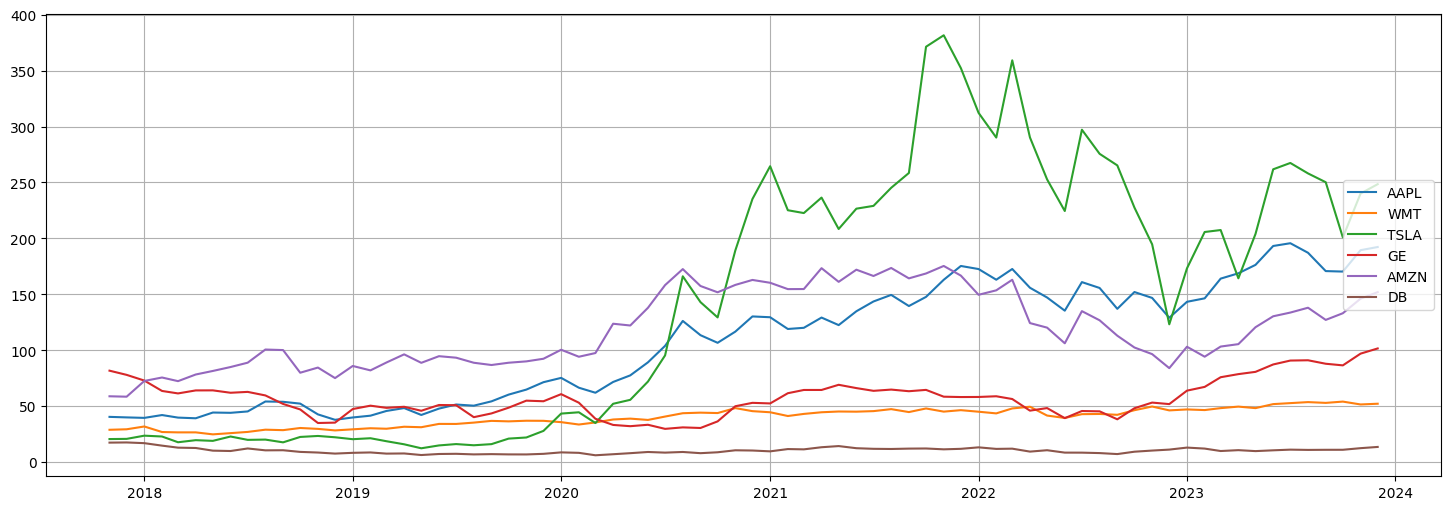

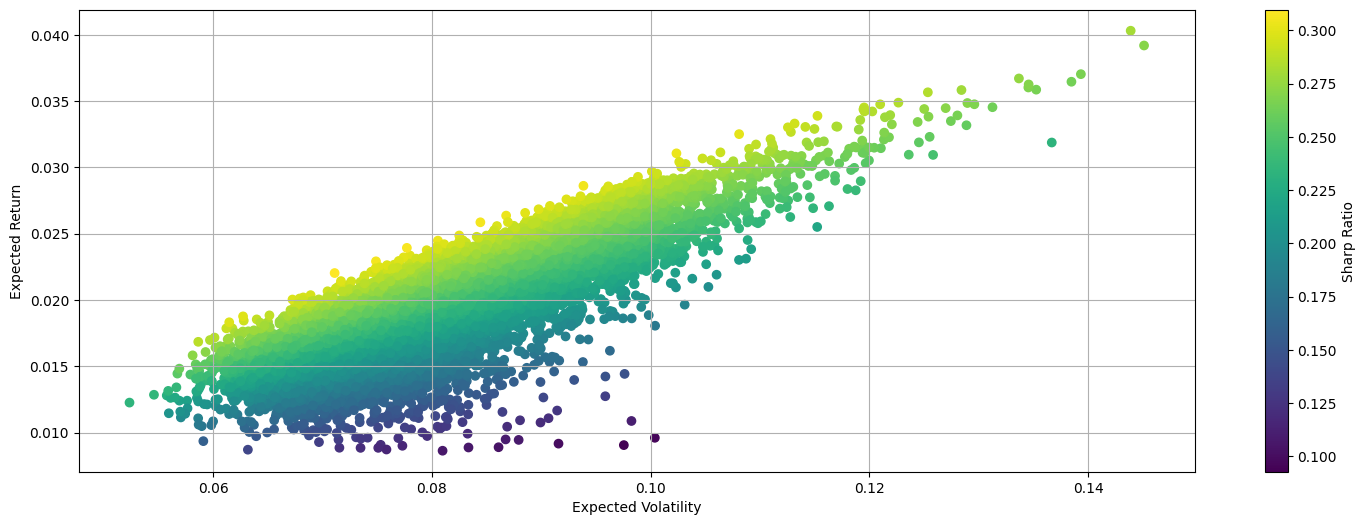

Optimal portfolio: [0.292 0.612 0.007 0.031 0.057 0.   ]
Expected return, volatility and sharp ratio: [0.01497744 0.05405365 0.27708468]


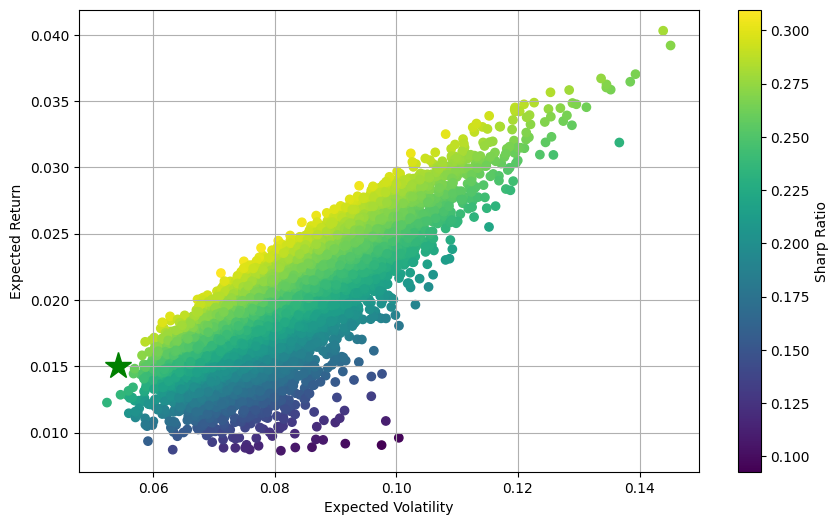

array([0.292, 0.612, 0.007, 0.031, 0.057, 0.   ])

In [4]:
model = MarkowitzModel(stocks, start_date, end_date)
model.get_optimal_weights_get_dataset('2017-11-01', end_date)
model.get_optimal_weights()

## Попытка в ребалансировку

Смотреть тут: https://readmedium.com/en/https:/python.plainenglish.io/how-to-improve-investment-portfolio-with-rebalancing-strategy-in-python-a58841ee8b5e

In [5]:
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']

In [6]:
stock_data = yf.download(stocks, start='2018-01-01', end='2024-01-01', interval='1mo')
stock_data = stock_data.dropna()

df = {}
for stock in stocks:
    # ticker = yf.Ticker(stock)
    # df[stock] = ticker.history(start = start_date, end = end_date, period='1mo')['Close']
    df[stock] = stock_data['Adj Close'][stock].pct_change()

df = pd.DataFrame(df)
df
# returns = np.log(df / df.shift(1))[1:]
# returns

[*********************100%%**********************]  6 of 6 completed


,AAPL,WMT,TSLA,GE,AMZN,DB
Date,,,,,,
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.063848,-0.155629,-0.031752,-0.127397,0.042429,-0.130862
2018-03-01,-0.054210,-0.011554,-0.224246,-0.034722,-0.043049,-0.122961
2018-04-01,-0.015020,0.000196,0.104347,0.043768,0.082075,-0.022890
2018-05-01,0.130764,-0.066923,-0.031201,0.000711,0.040539,-0.188873
...,...,...,...,...,...,...
2023-08-01,-0.043675,0.017203,-0.034962,0.002854,0.032391,-0.021563
2023-09-01,-0.087448,-0.012985,-0.030456,-0.034160,-0.078907,0.009183
2023-10-01,-0.002570,0.021760,-0.197346,-0.016482,0.046963,0.001820


In [7]:
import datetime
from dateutil.relativedelta import relativedelta
import heapq

In [17]:
def portfolio(stocks, dataset, numStocks, numRev):
    selected_stocks = stocks.copy()
    returns_array = []
    
    # Будем каждый месяц делать ребалансировку. Стартовая дата - 2018-01-01. Конечная дата - 2024-01-01.
    start_month = 1
    start_year = 2018
    end_month = 1
    end_year = 2024
    curr_datetime = datetime.datetime(start_year, start_month + 1, 1)
    next_datetime = curr_datetime + relativedelta(months=1)
    end_datetime = datetime.datetime(end_year, end_month, 1)

    i = 0
    while next_datetime + relativedelta(months=1) < end_datetime:
        next_datetime = curr_datetime + relativedelta(months=1)

        if len(selected_stocks) > 0:
            # Модель Марковица: считаем оптимальные веса для выбранных акций за месяц
            month_model = MarkowitzModel(selected_stocks, curr_datetime.strftime("%Y-%m-%d"), next_datetime.strftime("%Y-%m-%d"))
            month_model.get_optimal_weights_get_dataset((curr_datetime - relativedelta(months=2)).strftime("%Y-%m-%d"), next_datetime.strftime("%Y-%m-%d"))
            weights = month_model.get_optimal_weights(is_need_graphics=False)

            values = np.array(weights * df[selected_stocks].iloc[i,:])
            # returns_array.append(np.sum(values))
            returns_array.append(values.mean())
            indexes_of_max_value = heapq.nsmallest(numRev, range(len(values)), values.take)

            # убираем numRev наименее доходных акций
            selected_stocks = [stocks[ind] for ind in range(len(stocks)) if ind not in indexes_of_max_value]
        
        current_month_returns = np.array(df.iloc[i,:])
        # Добавляем ещё наиболее доходных акций в количестве numStocks - numRev.
        # Сортирую в порядке убывания по доходности за месяц
        indexes_of_max_value = heapq.nlargest(len(stocks), range(len(current_month_returns)), current_month_returns.take)
        
        # Хотим добавлять только те акции, которых еще нет в selected_stocks
        for ind in indexes_of_max_value:
            if stocks[ind] in selected_stocks:
                continue
            if len(selected_stocks) == numStocks:
                break
            selected_stocks.append(stocks[ind])


        print("From {} to {} was selected {}\n".format(
            curr_datetime.strftime("%Y-%m-%d"),
            next_datetime.strftime("%Y-%m-%d"),
            selected_stocks
        ))
        print("\t", weights)
        print("\t", df[selected_stocks].iloc[i,:])

        i += 1

        if i > 5:
            break
        curr_datetime = next_datetime

    # Рассчитываем для финального месяца: просто запускаем Марковица для вычисления весов
    month_model = MarkowitzModel(selected_stocks, curr_datetime.strftime("%Y-%m-%d"), end_datetime.strftime("%Y-%m-%d"))
    month_model.get_optimal_weights_get_dataset((curr_datetime - relativedelta(months=2)).strftime("%Y-%m-%d"), end_datetime.strftime("%Y-%m-%d"))
    weights = month_model.get_optimal_weights()
    returns = np.array(weights * df[selected_stocks].iloc[i,:])
    # returns_array.append(np.sum(returns))
    returns_array.append(returns.mean())
    print("-----------------------------------------------------")
    print("------------------- Final results -------------------")
    print("Selected stock:", selected_stocks)
    print("Weights:", weights)
    print("Returns:", returns)
    print("-----------------------------------------------------")

    return weights, returns, returns_array

['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.62  0.    0.11  0.191 0.078 0.   ]
Expected return, volatility and sharp ratio: [1.49729662e-02 1.36469332e-04 1.09716711e+02]
From 2018-02-01 to 2018-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.62  0.    0.11  0.191 0.078 0.   ]
	 TSLA   NaN
GE     NaN
AMZN   NaN
DB     NaN
Name: 2018-01-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [-0.00031015  0.06044238 -0.00513138]
From 2018-03-01 to 2018-04-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA   -0.031752
GE     -0.127397
AMZN    0.042429
DB     -0.130862
Name: 2018-02-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.301 0.699 0.   ]
Expected return, volatility and sharp ratio: [0.01500096 0.07855057 0.19097197]
From 2018-04-01 to 2018-05-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.    0.301 0.699 0.   ]
	 AAPL   -0.054210
GE     -0.034722
AMZN   -0.043049
DB     -0.122961
Name: 2018-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.385 0.108 0.264 0.244]
Expected return, volatility and sharp ratio: [1.50326228e-02 7.87906583e-06 1.90791944e+03]
From 2018-05-01 to 2018-06-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.385 0.108 0.264 0.244]
	 WMT     0.000196
TSLA    0.104347
AMZN    0.082075
DB     -0.022890
Name: 2018-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.    0.824 0.176]
Expected return, volatility and sharp ratio: [0.01506855 0.02107977 0.71483502]
From 2018-06-01 to 2018-07-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.    0.824 0.176]
	 WMT    -0.066923
TSLA   -0.031201
AMZN    0.040539
DB     -0.188873
Name: 2018-05-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.03690696 0.2369761  0.15574126]
From 2018-07-01 to 2018-08-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 WMT     0.044216
GE     -0.033381
AMZN    0.043065
DB     -0.031315
Name: 2018-06-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed


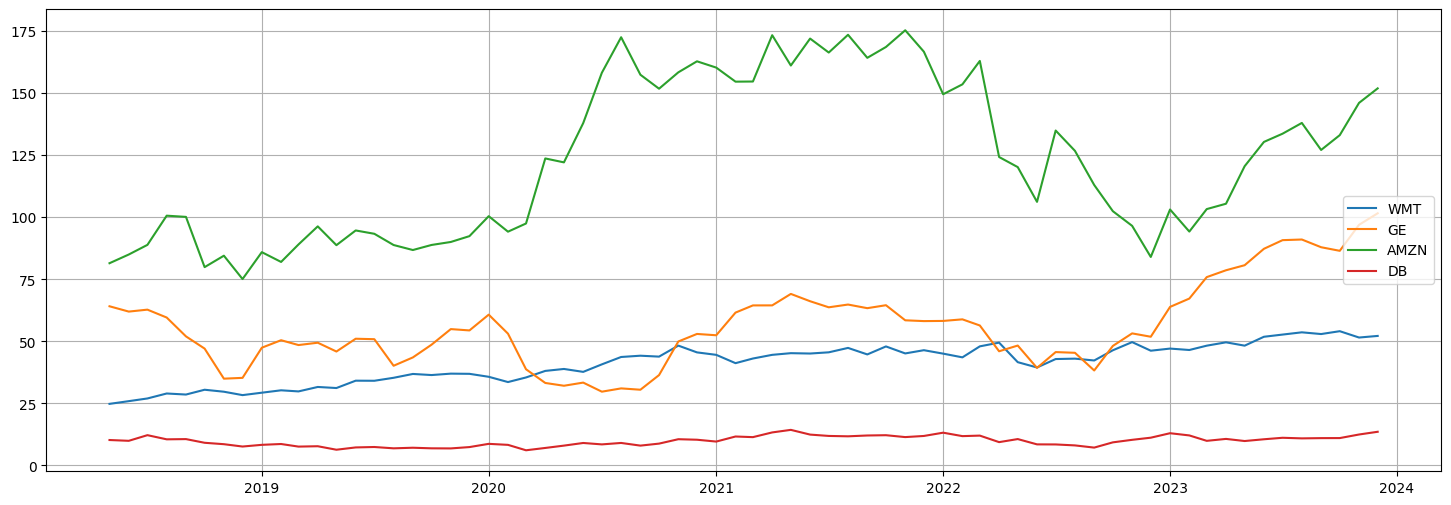

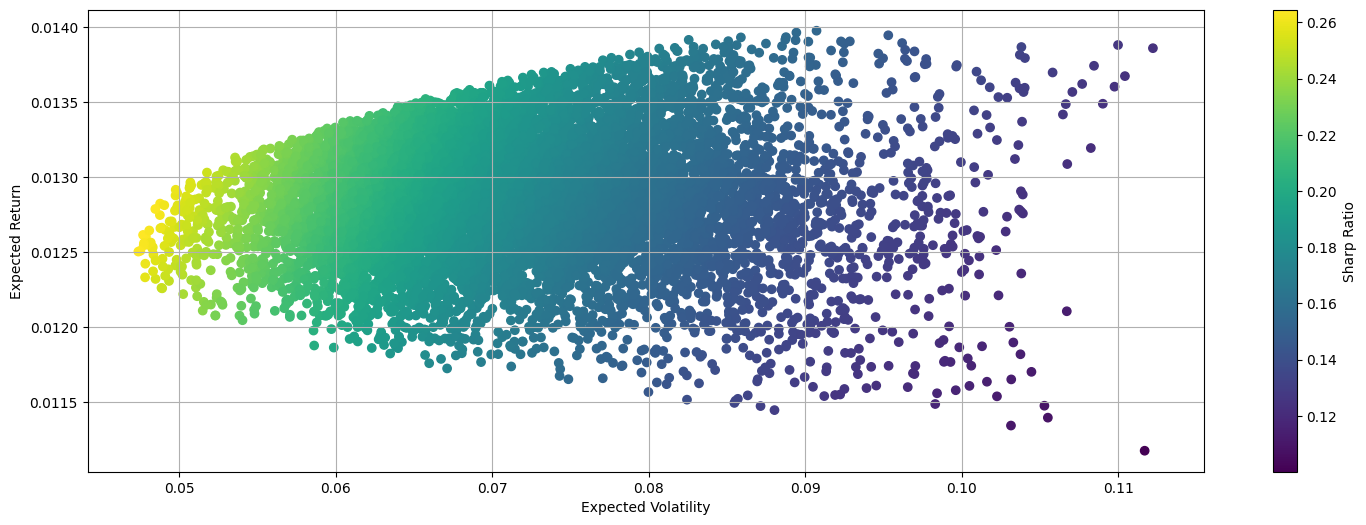

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.014104   0.12195557 0.11564871]


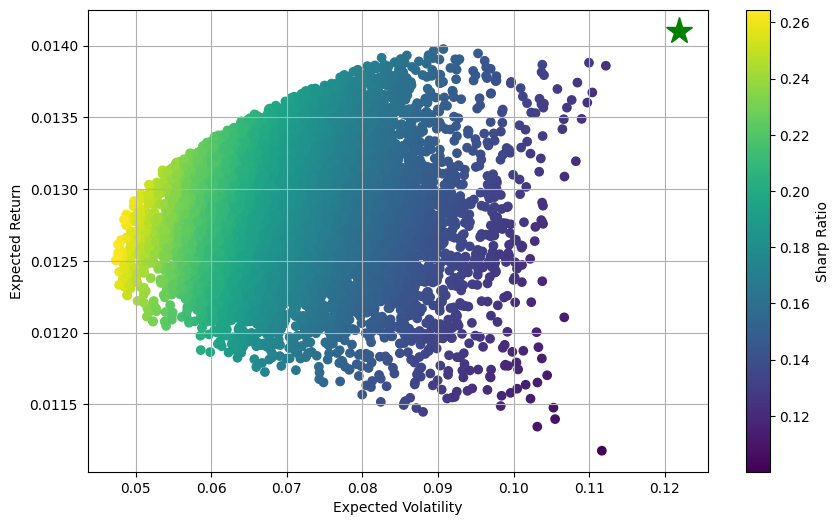

-----------------------------------------------------
------------------- Final results -------------------
Selected stock: ['WMT', 'GE', 'AMZN', 'DB']
Weights: [0. 1. 0. 0.]
Returns: [0.         0.01263238 0.         0.        ]
-----------------------------------------------------


In [18]:
print(stocks)
_, _, returns = portfolio(stocks, df, 4, 2)

In [10]:
print(returns)
returns = np.array(returns[1:])
print(returns)

[nan, 0.010607265900500318, -0.010135684786026384, 0.003763564703420124, 4.071865854436002e-05, 0.0511185903184625, 0.005760280787282532, 0.007423074592146089, -0.0029217180694991437, 0.0037267628937595505, 0.014417938113104933, -0.007709443867863398, 0.008596184736846202, 0.0037491138949504507, -0.0014430374286832047, 0.020464686367292484, -0.01828830062715866, 0.016697936637520228, 0.02030563243575023, -0.006531232263569083, 0.003743032877799861, 0.0037528281047229627, 0.0037440444825657753, 0.006530423566118271, 0.022819166819383806, -0.015553430033407645, -0.0011767848738237878, 0.003757341500715972, -0.004563211522335639, 0.016395395060401524, -0.009771902400789234, 0.02993890820358498, 0.002944168991663554, -0.006370807694154154, 0.02529733209512397, 0.010758949426155122, 0.003747178113754068, 0.0037790664846723814, 0.01176237257463264, 0.008584472677785837, 0.003763992631217241, 0.013804384146953168, -0.0023476687560681666, 0.0037507978414103244, 0.003741398107523712, 0.00533836

In [11]:
# генерируем массив дат с шагом в месяц
start_month = 1
start_year = 2018
end_month = 1
end_year = 2024
curr_month = start_month
curr_year = start_year

start_datetime = datetime.datetime(start_year, start_month, 1)
curr_datetime = datetime.datetime(start_year, start_month, 1)
end_datetime = datetime.datetime(end_year, end_month, 1)

dates = []
while curr_datetime < end_datetime:
    dates.append(curr_datetime.strftime("%Y-%m-%d")) 
    curr_datetime += relativedelta(months=1)
dates.append(end_datetime.strftime("%Y-%m-%d"))
print(dates)

['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01', '2023

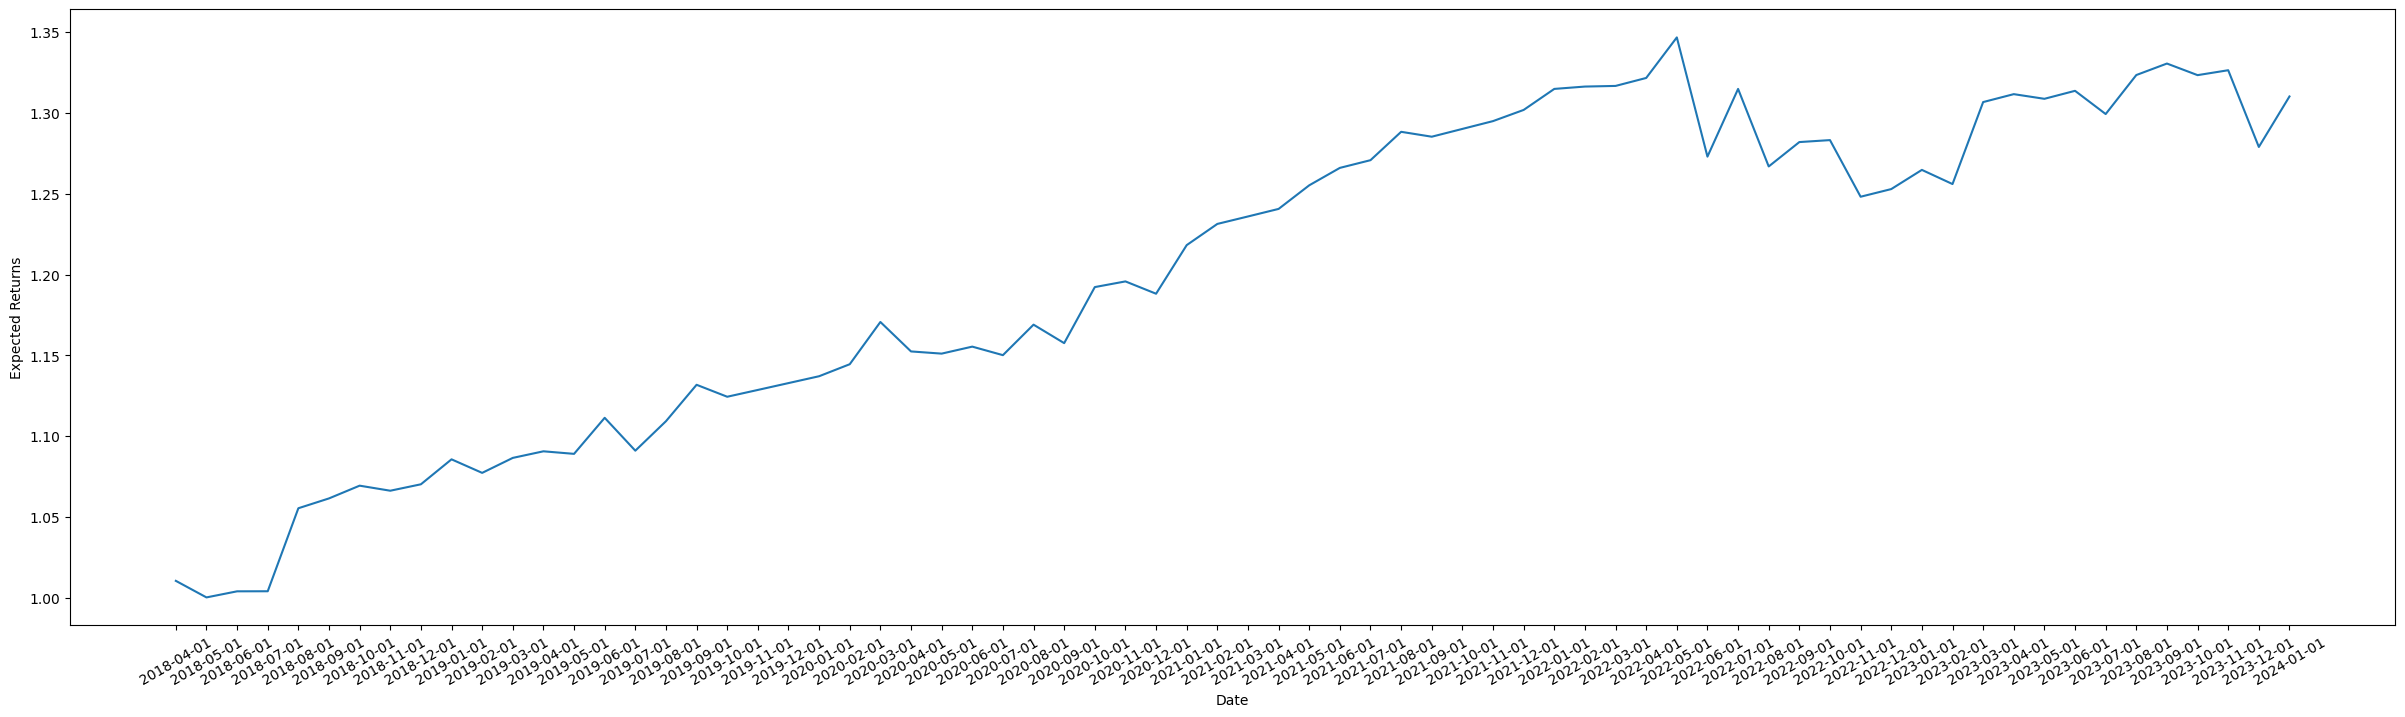

In [15]:
# Рисуем график для нашей стратегии с ребалансировкой

plt.figure(figsize = (30,8))
plt.xlabel('Date')
plt.ylabel('Expected Returns')
plt.xticks(rotation=30)
plt.plot(
    dates[2:],
    (1 + returns).cumprod(),
    # markersize = 20
)
plt.show()

[*********************100%%**********************]  1 of 1 completed


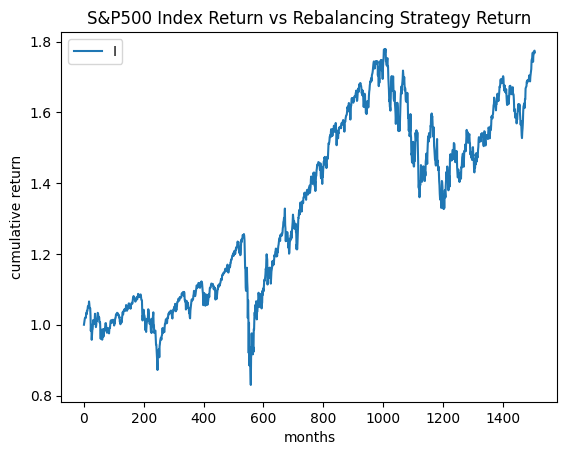

In [16]:
# Рисуем график для общепринятого индекса S&P500

sp500 = yf.download("^GSPC", start = start_datetime, end = end_datetime, period='1mo')
close = sp500["Close"]
sp500["monthly_returns"] = sp500["Adj Close"].pct_change().fillna(0)
plt.plot((1+sp500["monthly_returns"].reset_index(drop=True)).cumprod())
plt.title("S&P500 Index Return vs Rebalancing Strategy Return")
plt.ylabel("cumulative return")
plt.xlabel("months")
plt.legend("Index Return")

## Видим, что нам не удалось перепрыгнуть S&P500, но это норм, мало кому удается его обогнать (вроде бы)